In [27]:
%pylab inline
from __future__ import print_function, division

import os
import os.path as osp
import matplotlib.pyplot as plt

from warnings import warn
import datetime, time
import glob as gb
from six import string_types
import argparse
import json
import time
import re

import numpy as np
import scipy.linalg as lin
import scipy.stats as sst

Populating the interactive namespace from numpy and matplotlib


In [90]:
import smpce_data_to_corr as smp
import layout as lo
import utils._utils as ucr
import correlation2results as c2r
import signals2results as s2r

In [91]:
np.set_printoptions(precision=3)
lo = reload(lo)
ucr = reload(ucr)
smp = reload(smp)
c2r = reload(c2r)
s2r = reload(s2r)

## Read the signals, form a correlation matrix

In [92]:
# get the list of npz corresponding to a specific analysis
# use directory layout for this 
dbase = '/home/jb/data/simpace/rename_files'

params = smp.get_params(dbase, addjson=None)
print(params['layout']['signals']['pre'])
print(params['analysis']['compute_sess_mask'])

params = smp.get_params(dbase, addjson='NR_0')
print(params['layout']['signals']['pre'])
print(params['analysis']['compute_sess_mask'])

params = smp.get_params(dbase, addjson='NR_1')
print(params['layout']['signals']['pre'])
print(params['analysis']['compute_sess_mask'])

dstate = {'sub':1}
pth = lo._get_pth(params['layout'], 'signals', glob=True)
glb = lo._get_glb(params['layout'], 'signals', glob=True)
print(pth)
print(glb)

signal_
True
NR_0_signal_
False
NR_1_signal_
False
/home/jb/data/simpace/rename_files/sub*/sess*/preproc/extracted_signals
NR_1_signal_sub*_sess*_run*


In [93]:
# print("\n".join(s2r.get_signals_filenames(dbase, addjson=None, condpat='low')))

In [94]:
np.set_printoptions(precision=3)
pipelines = [None, 'NR_0', 'NR_1', 'NR_2', 'NR_3', 'NR_4']

ordered_conds = s2r.ordered_conds()

for pipe in pipelines:
    conds, pipeline = s2r.create_conds_filenames(dbase, addjson=pipe)
    common_labels = s2r._get_common_labels(conds, idx0=1)
    conds_arr, stored_params = s2r.compute_corr_mtx(conds, common_labels)
    #print(conds_arr['none'].shape, pipeline)
    #conds_arr.keys()

    
    bias = s2r.smpce_bias(conds_arr, ordered_conds) #, s2r.smpce_var(conds_arr, ordered_conds))
    vari = s2r.smpce_var(conds_arr, ordered_conds) #, s2r.smpce_var(conds_arr, ordered_conds))
    

    print('pipeline:', pipeline)
    print('-'*77)
    for k in ordered_conds:
        avrg = s2r.smpce_mean_cond(conds_arr, k)
        print("{0:5s} : {1:5.2f}   {2:5.2f}  mean: {3:5.2f}  mean abs: {4:5.3f}  {5:5.2f}".format(
                k, lin.norm(bias[k]), lin.norm(vari[k]), 
                avrg.mean(), np.abs(avrg).mean(), vari[k].mean()))
        #print('check', vari[k][[1,2,3,4],[1,2,3,4]]) #  bias[k].shape,
    print("\n")

pipeline: default
-----------------------------------------------------------------------------
none  :  0.00   12.98  mean:  0.46  mean abs: 0.458   0.15
low   :  5.66   12.25  mean:  0.46  mean abs: 0.461   0.14
med   :  7.54   11.69  mean:  0.44  mean abs: 0.444   0.14
high  : 12.56    8.82  mean:  0.39  mean abs: 0.393   0.10


pipeline: NR_0
-----------------------------------------------------------------------------
none  :  0.00   14.16  mean:  0.38  mean abs: 0.387   0.16
low   :  6.84   13.04  mean:  0.39  mean abs: 0.391   0.15
med   :  9.07   14.92  mean:  0.42  mean abs: 0.417   0.17
high  : 10.76   12.55  mean:  0.39  mean abs: 0.393   0.15


pipeline: NR_1
-----------------------------------------------------------------------------
none  :  0.00   15.12  mean:  0.02  mean abs: 0.198   0.18
low   :  8.41   14.73  mean:  0.03  mean abs: 0.197   0.17
med   :  9.92   14.39  mean:  0.02  mean abs: 0.190   0.17
high  : 12.05   13.63  mean:  0.02  mean abs: 0.168   0.16


pipe

3403
NR_4


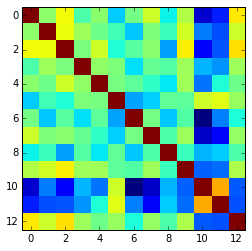

In [102]:
c = s2r.smpce_corr_btw_sess_cond(conds_arr['none'])
plt.imshow(c,interpolation='nearest')
print(pipeline)

In [82]:

def plot_pipeline_summary(conds_summary, title, pipeline=None, minall=-.4, maxall=.4):

    f, axes = plt.subplots(1, 4, sharey=True, figsize=(18,4))
    f.subplots_adjust(wspace=0.1)
    f.subplots_adjust(right=0.85)
    titlestr = 'Pipeline ' + pipeline + ' - ' + title
    f.suptitle(titlestr, fontsize=24, fontweight='bold', x=.5, y=.01)
    left, bottom, width, height = .87, 0.12, 0.02, 0.77 
    cbar_ax = f.add_axes([left, bottom, width, height])

    minall_ = np.min(np.asarray([conds_summary[k].min() for k in ordered_conds]))
    maxall_ = np.max(np.asarray([conds_summary[k].max() for k in ordered_conds]))
    if not minall: minall=minall_
    if not maxall: maxall=maxall_

    for axe,k in zip(axes,ordered_conds): 
        m = axe.imshow(conds_summary[k], interpolation='nearest', vmin=minall, vmax=maxall)
        axe.set_title(k, fontsize=20)

    cm = f.colorbar(m, cax=cbar_ax)
    return minall_, maxall_
    

(0.0, 0.35913068011342059)

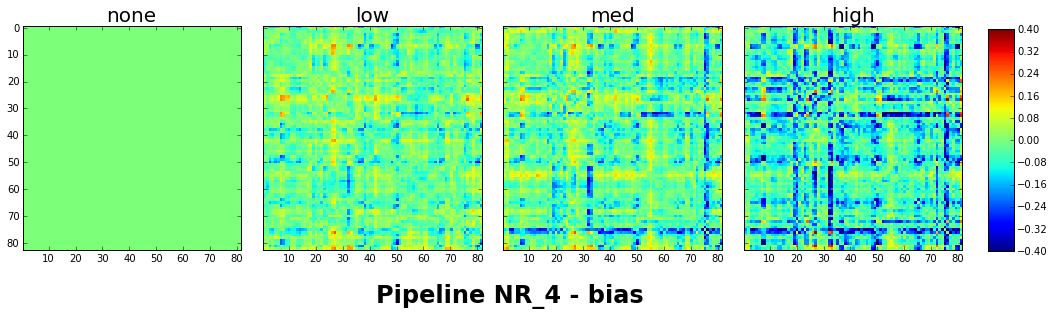

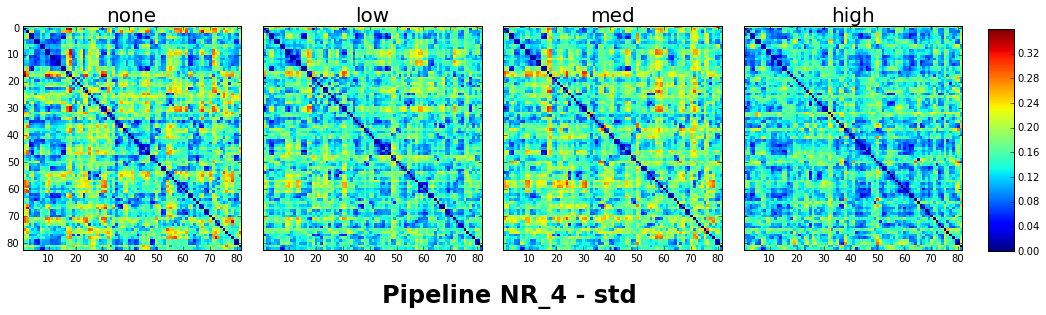

In [26]:
plot_pipeline_summary(bias, 'bias',  pipeline=pipeline)
plot_pipeline_summary(vari, 'std', pipeline=pipeline, minall=None, maxall=None)

In [ ]:
for pipe in pipelines:
    conds, pipeline = s2r.create_conds_filenames(dbase, addjson=pipe)
    common_labels = s2r._get_common_labels(conds, idx0=1)
    conds_arr, stored_params = s2r.compute_corr_mtx(conds, common_labels)

    